In [1]:
import sys
import numpy as np

sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import random
# Load state sequence and data from the pickle file
import pickle
with open('/Users/david/Documents/mastersCode/ubm/final/tests/train-test-val.pkl', 'rb') as file:
    sample_holder = pickle.load(file)

# with open('/Users/david/Documents/mastersCode/ubm/final/tests/comparison_of_fe_methods/samples_128_log_power.pickle', 'rb') as file:
#     sample_holder = pickle.load(file)

In [3]:
train = sample_holder['train']
val = sample_holder['val']
test = sample_holder['test']


In [4]:
from final import useful
def get_feature(samp):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000,n_mfcc=13).T
    feat = useful.get_log_power_feature(samp, nfft=128)
    return feat

In [5]:
train.features = []
for sample in train.samples:
    train.features.append(get_feature(sample))

val.features = []
for sample in val.samples:
    val.features.append(get_feature(sample))

test.features = []
for sample in test.samples:
    test.features.append(get_feature(sample))

In [121]:

def filter_features_by_label(sample_holder, label):
    indicis = sample_holder.sample_labels == label
    filtered_features = [item for item, condition in zip(sample_holder.features, indicis) if condition]
    return filtered_features

whale_label = 1

train_filtered_features = filter_features_by_label(train, whale_label)
val_filtered_features = filter_features_by_label(val, whale_label)
test_filtered_features = filter_features_by_label(test, whale_label)


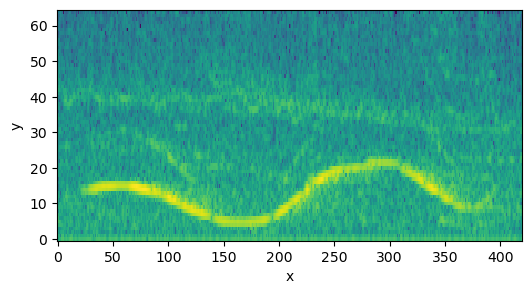

In [122]:
from final.useful import vis_helper
vis_helper(train_filtered_features[0])

In [130]:
# # get_log_power_feature()
# labels = np.array(sample_holder.sample_labels)
# samples = sample_holder.samples
# features = sample_holder.features
# from sklearn.utils import check_random_state
# rs = check_random_state(546)
# label = 1
# indices = np.array(labels == label)
# selected_features = [feats for feats, select in zip(features, indices) if select]
# lens = []
#
# for feat in selected_features[:5]:
#     lens.append(len(feat))
# lens = np.array(lens)
#
concatenated_list = [
    np.concatenate(random.sample(train_filtered_features, 5))
    for _ in range(10)
]

#
# train_filtered_features # + [train_filtered_features[2]]
#
#
#     [
#     np.concatenate(random.sample(train_filtered_features, 1))
#     for _ in range(10)
# ]

In [134]:
import final.models.hdphmm.hdphmmwl.hdphmmwl as hdphmm
from final.models.hdphmm.helpers.plot_hmm import plot_hmm_data
import final.models.hdphmm.hdphmmwl.consts as const
import final.models.hdphmm.hdphmmwl.numba_wl as numba
from importlib import reload
reload(const)
reload(numba)
reload(hdphmm)

sbp = {
    const.ALPHA0: 100,
    const.GAMMA0: 500,
    const.KAPPA0: 50,
}
sbp[const.RHO0] = sbp[const.KAPPA0] / ( sbp[const.KAPPA0] + sbp[const.ALPHA0])
temp = 1
hdp_hmm = hdphmm.HDPHMMWL(concatenated_list, 15, iterations=15, sbp=sbp, feature_a=11, feature_b=12)

# hdp_hmm.gamma0 = 0.01
# hdp_hmm.nu0 = 200
# hdp_hmm.V0 = np.eye(hdp_hmm.D) * 1000

sbp given


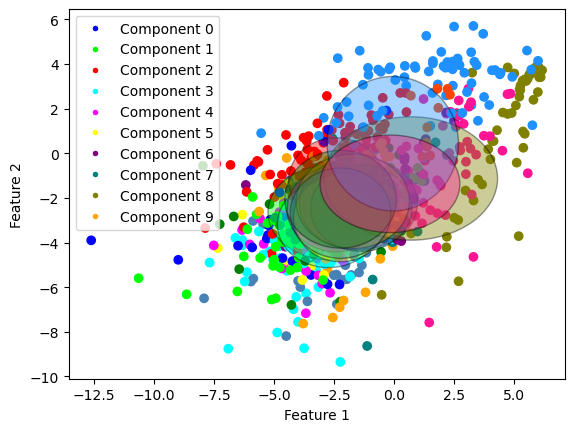

In [135]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
hdp_hmm.create_hmm()
hdp_hmm.plot_hmmlearn(15,16,1)

iterations per sample:  1
Gibb sampling on sample index:  0 outer it:  0
it:  0  || Likelihood:  -22977.507609981865  || n_components:  8
Gibb sampling on sample index:  1 outer it:  0
it:  0  || Likelihood:  -23256.940219505803  || n_components:  9
Gibb sampling on sample index:  2 outer it:  0
it:  0  || Likelihood:  -22691.810903342845  || n_components:  9
Gibb sampling on sample index:  3 outer it:  0
it:  0  || Likelihood:  -23088.3246340556  || n_components:  8
Gibb sampling on sample index:  4 outer it:  0
it:  0  || Likelihood:  -23779.892318362105  || n_components:  9
Gibb sampling on sample index:  5 outer it:  0
it:  0  || Likelihood:  -22638.79883803001  || n_components:  8
Gibb sampling on sample index:  6 outer it:  0
it:  0  || Likelihood:  -23297.8935579838  || n_components:  8
Gibb sampling on sample index:  7 outer it:  0
it:  0  || Likelihood:  -22728.41696926655  || n_components:  8
Gibb sampling on sample index:  8 outer it:  0
it:  0  || Likelihood:  -23802.678316

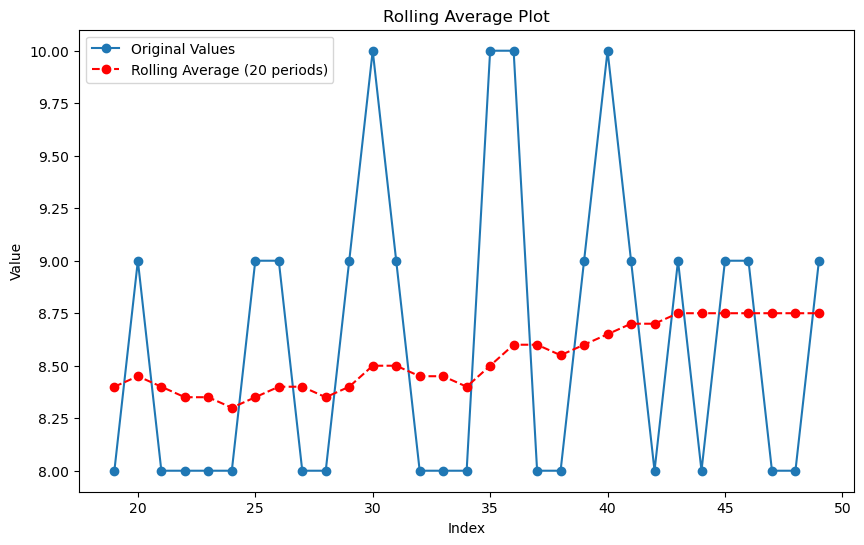

8.54
0.6390618123468182
Gibb sampling on sample index:  0 outer it:  5
it:  0  || Likelihood:  -22991.711720776668  || n_components:  9
Gibb sampling on sample index:  1 outer it:  5
it:  0  || Likelihood:  -23218.259267904574  || n_components:  9
Gibb sampling on sample index:  2 outer it:  5
it:  0  || Likelihood:  -22646.25967610297  || n_components:  8
Gibb sampling on sample index:  3 outer it:  5
it:  0  || Likelihood:  -23098.40098245717  || n_components:  9
Gibb sampling on sample index:  4 outer it:  5
it:  0  || Likelihood:  -23864.956314907973  || n_components:  8
Gibb sampling on sample index:  5 outer it:  5
it:  0  || Likelihood:  -22600.269980219407  || n_components:  9
Gibb sampling on sample index:  6 outer it:  5
it:  0  || Likelihood:  -23333.232214568037  || n_components:  9
Gibb sampling on sample index:  7 outer it:  5
it:  0  || Likelihood:  -22652.781896743636  || n_components:  8
Gibb sampling on sample index:  8 outer it:  5
it:  0  || Likelihood:  -23773.9433

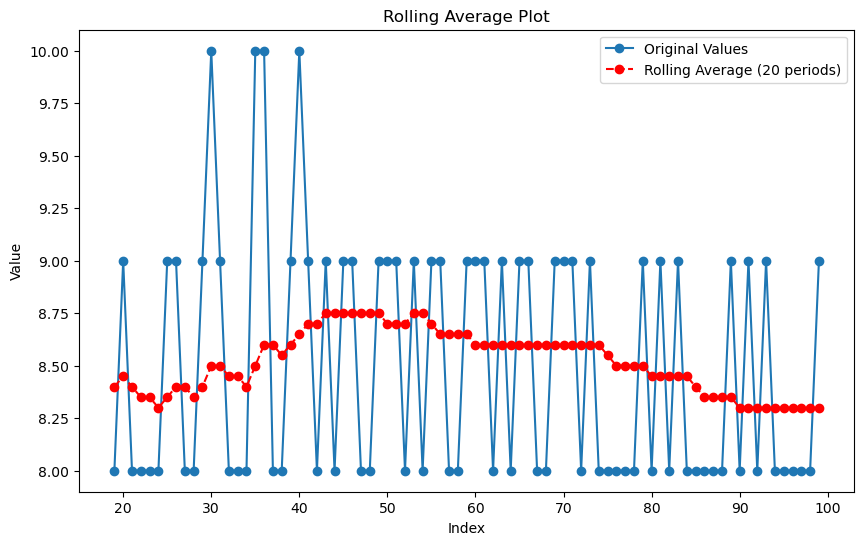

8.44
0.4963869458396343
Gibb sampling on sample index:  0 outer it:  10
it:  0  || Likelihood:  -22940.43348836717  || n_components:  8
Gibb sampling on sample index:  1 outer it:  10
it:  0  || Likelihood:  -23227.002353719057  || n_components:  9
Gibb sampling on sample index:  2 outer it:  10
it:  0  || Likelihood:  -22698.924572232256  || n_components:  8
Gibb sampling on sample index:  3 outer it:  10
it:  0  || Likelihood:  -23102.126745603073  || n_components:  9
Gibb sampling on sample index:  4 outer it:  10
it:  0  || Likelihood:  -23875.26060094705  || n_components:  8
Gibb sampling on sample index:  5 outer it:  10
it:  0  || Likelihood:  -22660.5923447086  || n_components:  8
Gibb sampling on sample index:  6 outer it:  10
it:  0  || Likelihood:  -23313.435304079787  || n_components:  8
Gibb sampling on sample index:  7 outer it:  10
it:  0  || Likelihood:  -22764.904063917085  || n_components:  8
Gibb sampling on sample index:  8 outer it:  10
it:  0  || Likelihood:  -237

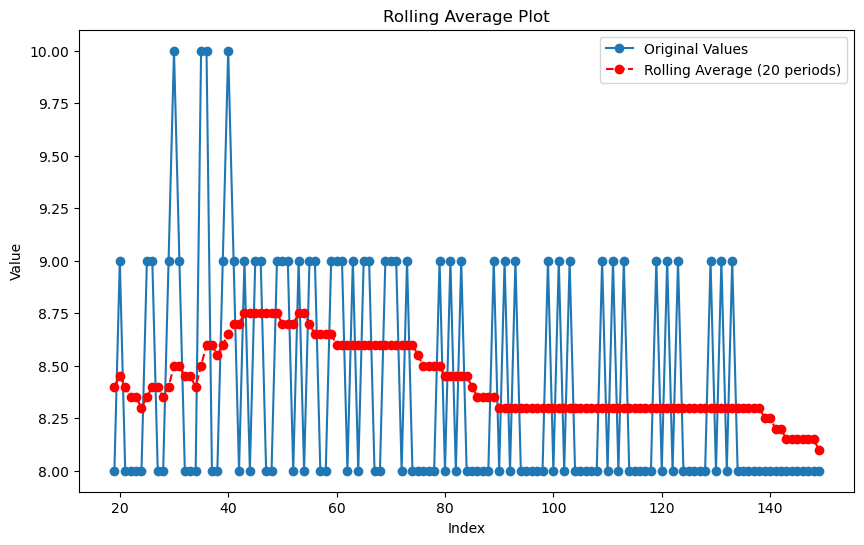

8.22
0.41424630354415964
8.33
0.47021271782034985
Gibb sampling on sample index:  0 outer it:  15
it:  0  || Likelihood:  -23001.52579117398  || n_components:  8
Gibb sampling on sample index:  1 outer it:  15
it:  0  || Likelihood:  -23260.454620927383  || n_components:  8
Gibb sampling on sample index:  2 outer it:  15
it:  0  || Likelihood:  -22661.070084197272  || n_components:  8
Gibb sampling on sample index:  3 outer it:  15
it:  0  || Likelihood:  -23087.71717577552  || n_components:  8
Gibb sampling on sample index:  4 outer it:  15
it:  0  || Likelihood:  -23900.150895363524  || n_components:  8
Gibb sampling on sample index:  5 outer it:  15
it:  0  || Likelihood:  -22648.926883802593  || n_components:  8
Gibb sampling on sample index:  6 outer it:  15
it:  0  || Likelihood:  -23312.499495352135  || n_components:  8
Gibb sampling on sample index:  7 outer it:  15
it:  0  || Likelihood:  -22682.054946483055  || n_components:  8
Gibb sampling on sample index:  8 outer it:  15


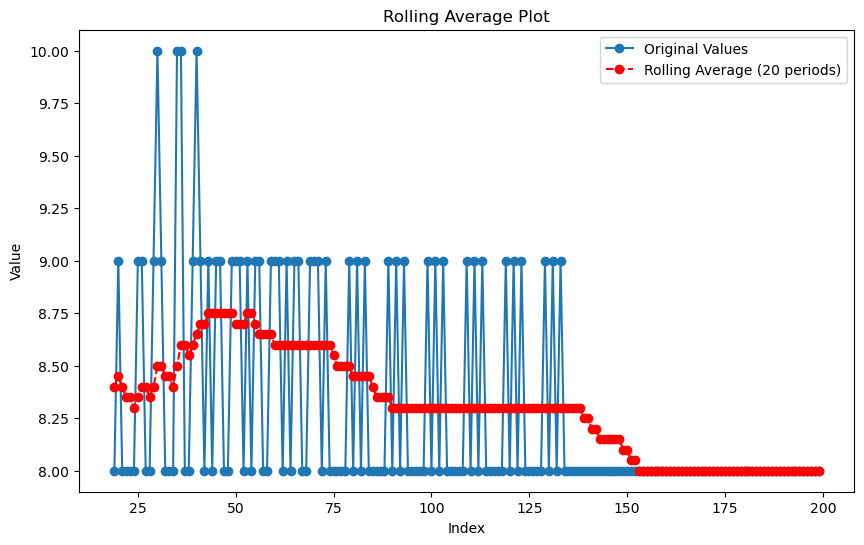

8.0
0.0
8.11
0.3128897569432403
Gibb sampling on sample index:  0 outer it:  20
it:  0  || Likelihood:  -22961.26731777402  || n_components:  8
Gibb sampling on sample index:  1 outer it:  20
it:  0  || Likelihood:  -23249.460378116462  || n_components:  8
Gibb sampling on sample index:  2 outer it:  20
it:  0  || Likelihood:  -22669.970288042055  || n_components:  8
Gibb sampling on sample index:  3 outer it:  20
it:  0  || Likelihood:  -23128.46247044821  || n_components:  8
Gibb sampling on sample index:  4 outer it:  20
it:  0  || Likelihood:  -23889.949543193365  || n_components:  8
Gibb sampling on sample index:  5 outer it:  20
it:  0  || Likelihood:  -22649.90115953668  || n_components:  8
Gibb sampling on sample index:  6 outer it:  20
it:  0  || Likelihood:  -23345.810169320728  || n_components:  8
Gibb sampling on sample index:  7 outer it:  20
it:  0  || Likelihood:  -22709.247474474054  || n_components:  8
Gibb sampling on sample index:  8 outer it:  20
it:  0  || Likeliho

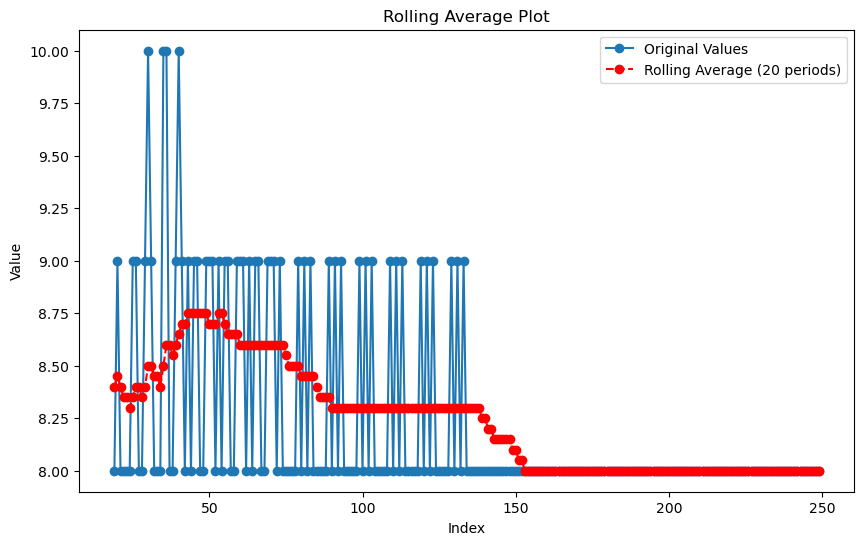

8.0
0.0
8.0
0.0
Gibb sampling on sample index:  0 outer it:  25
it:  0  || Likelihood:  -22948.64318476712  || n_components:  8
Gibb sampling on sample index:  1 outer it:  25
it:  0  || Likelihood:  -23240.26958254093  || n_components:  8
Gibb sampling on sample index:  2 outer it:  25
it:  0  || Likelihood:  -22675.42755043752  || n_components:  8
Gibb sampling on sample index:  3 outer it:  25
it:  0  || Likelihood:  -23126.029514031554  || n_components:  8
Gibb sampling on sample index:  4 outer it:  25
it:  0  || Likelihood:  -23818.357255004037  || n_components:  8
Gibb sampling on sample index:  5 outer it:  25
it:  0  || Likelihood:  -22654.90560137771  || n_components:  8
Gibb sampling on sample index:  6 outer it:  25
it:  0  || Likelihood:  -23280.34028554145  || n_components:  8
Gibb sampling on sample index:  7 outer it:  25
it:  0  || Likelihood:  -22687.845803125172  || n_components:  8
Gibb sampling on sample index:  8 outer it:  25
it:  0  || Likelihood:  -23844.378660

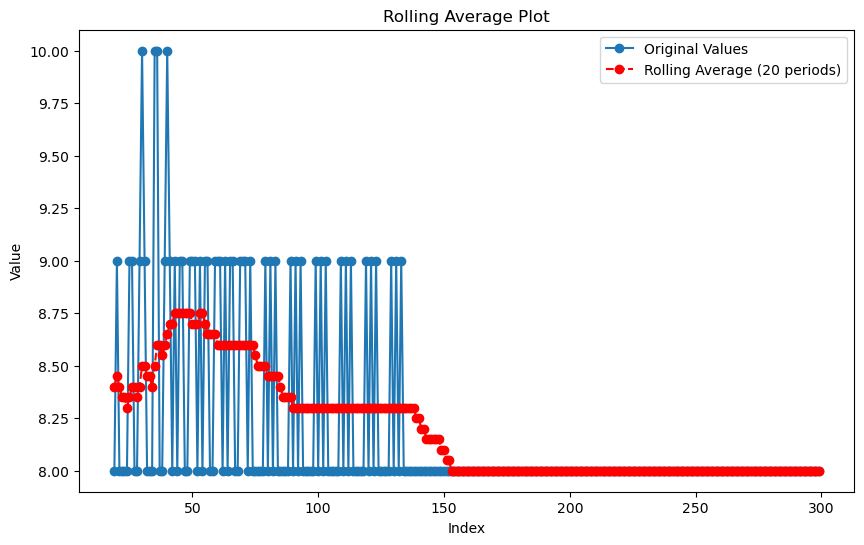

8.0
0.0
8.0
0.0
Gibb sampling on sample index:  0 outer it:  30
it:  0  || Likelihood:  -22980.045705574983  || n_components:  8
Gibb sampling on sample index:  1 outer it:  30
it:  0  || Likelihood:  -23240.97730463551  || n_components:  8
Gibb sampling on sample index:  2 outer it:  30
it:  0  || Likelihood:  -22671.63351491325  || n_components:  8
Gibb sampling on sample index:  3 outer it:  30
it:  0  || Likelihood:  -23064.379127685166  || n_components:  8
Gibb sampling on sample index:  4 outer it:  30
it:  0  || Likelihood:  -23856.3768205384  || n_components:  8
Gibb sampling on sample index:  5 outer it:  30
it:  0  || Likelihood:  -22639.57731832742  || n_components:  8
Gibb sampling on sample index:  6 outer it:  30
it:  0  || Likelihood:  -23300.5748435518  || n_components:  8
Gibb sampling on sample index:  7 outer it:  30
it:  0  || Likelihood:  -22698.916178190233  || n_components:  8
Gibb sampling on sample index:  8 outer it:  30
it:  0  || Likelihood:  -23757.36837801

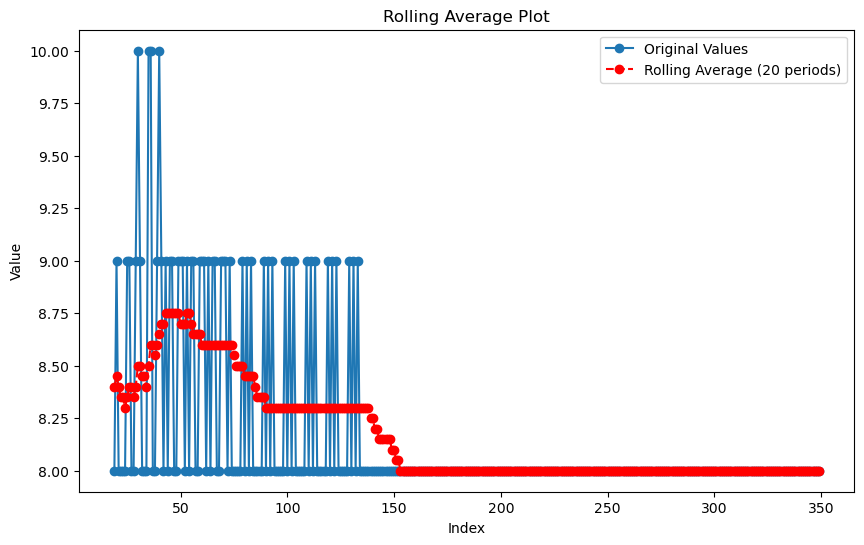

8.0
0.0
8.0
0.0
Gibb sampling on sample index:  0 outer it:  35
it:  0  || Likelihood:  -22942.179196411154  || n_components:  8
Gibb sampling on sample index:  1 outer it:  35
it:  0  || Likelihood:  -23252.86280953816  || n_components:  8
Gibb sampling on sample index:  2 outer it:  35
it:  0  || Likelihood:  -22651.76231319637  || n_components:  8
Gibb sampling on sample index:  3 outer it:  35
it:  0  || Likelihood:  -23108.694397494044  || n_components:  8
Gibb sampling on sample index:  4 outer it:  35
it:  0  || Likelihood:  -23832.152927328487  || n_components:  8
Gibb sampling on sample index:  5 outer it:  35
it:  0  || Likelihood:  -22618.211414506924  || n_components:  8
Gibb sampling on sample index:  6 outer it:  35
it:  0  || Likelihood:  -23275.962846178558  || n_components:  8
Gibb sampling on sample index:  7 outer it:  35
it:  0  || Likelihood:  -22680.366618416312  || n_components:  8
Gibb sampling on sample index:  8 outer it:  35
it:  0  || Likelihood:  -23779.442

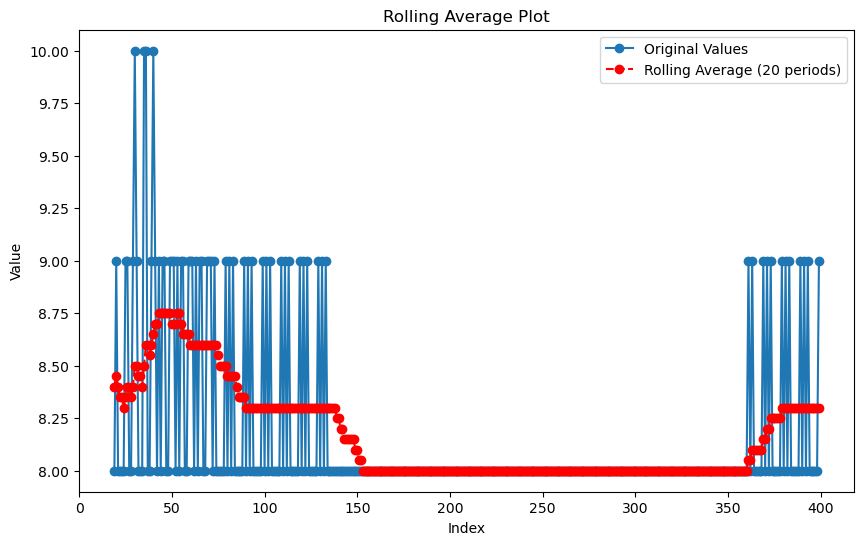

8.24
0.4270831300812525
8.12
0.32496153618543844
Gibb sampling on sample index:  0 outer it:  40
it:  0  || Likelihood:  -22942.081339915116  || n_components:  8
Gibb sampling on sample index:  1 outer it:  40
it:  0  || Likelihood:  -23250.551385282713  || n_components:  9
Gibb sampling on sample index:  2 outer it:  40
it:  0  || Likelihood:  -22692.14219065933  || n_components:  8
Gibb sampling on sample index:  3 outer it:  40
it:  0  || Likelihood:  -23079.645406970707  || n_components:  9
Gibb sampling on sample index:  4 outer it:  40
it:  0  || Likelihood:  -23864.678138600313  || n_components:  8
Gibb sampling on sample index:  5 outer it:  40
it:  0  || Likelihood:  -22666.779311612623  || n_components:  8
Gibb sampling on sample index:  6 outer it:  40
it:  0  || Likelihood:  -23340.72858108452  || n_components:  8
Gibb sampling on sample index:  7 outer it:  40
it:  0  || Likelihood:  -22687.583671997494  || n_components:  8
Gibb sampling on sample index:  8 outer it:  40
i

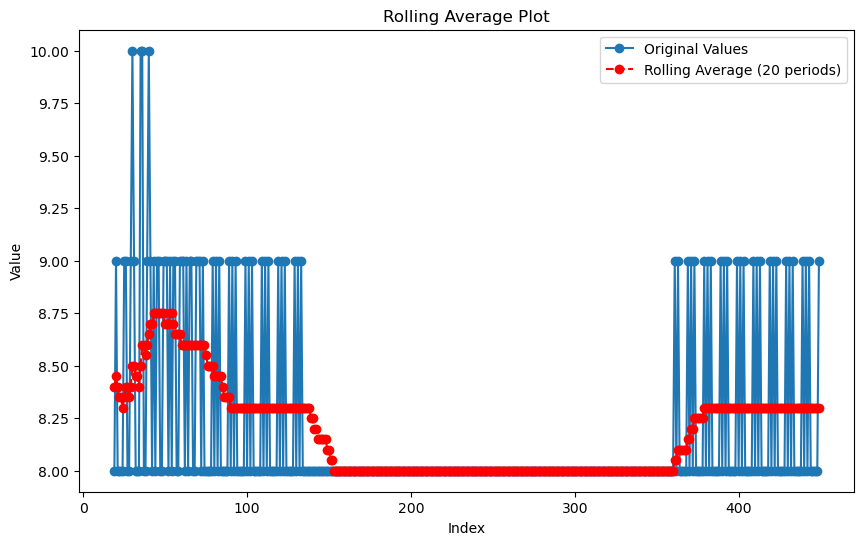

8.3
0.458257569495584
8.27
0.4439594576084623
Gibb sampling on sample index:  0 outer it:  45
it:  0  || Likelihood:  -22954.29561623034  || n_components:  8
Gibb sampling on sample index:  1 outer it:  45
it:  0  || Likelihood:  -23251.806391878807  || n_components:  9
Gibb sampling on sample index:  2 outer it:  45
it:  0  || Likelihood:  -22654.182038555813  || n_components:  8
Gibb sampling on sample index:  3 outer it:  45
it:  0  || Likelihood:  -23130.55331416379  || n_components:  9
Gibb sampling on sample index:  4 outer it:  45
it:  0  || Likelihood:  -23840.69678410781  || n_components:  8
Gibb sampling on sample index:  5 outer it:  45
it:  0  || Likelihood:  -22664.778440599934  || n_components:  8
Gibb sampling on sample index:  6 outer it:  45
it:  0  || Likelihood:  -23334.568143915752  || n_components:  8
Gibb sampling on sample index:  7 outer it:  45
it:  0  || Likelihood:  -22676.199749891726  || n_components:  8
Gibb sampling on sample index:  8 outer it:  45
it:  

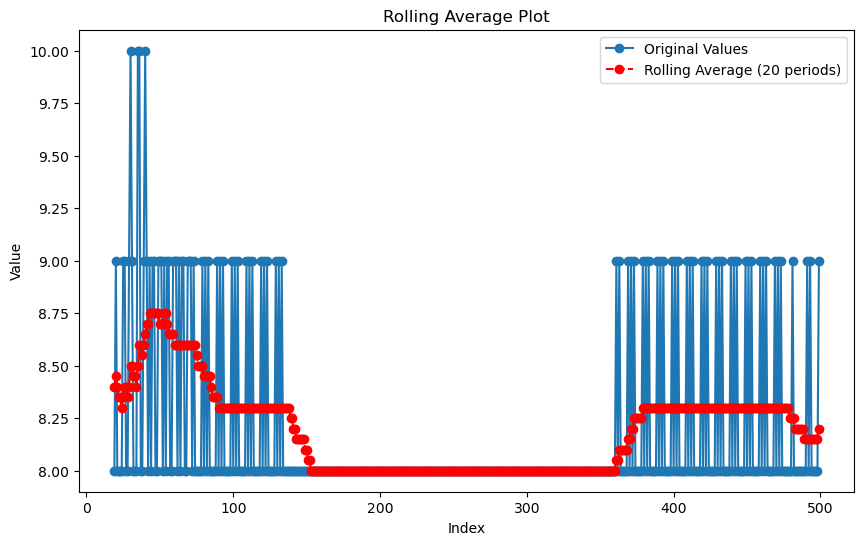

8.24
0.4270831300812525
8.27
0.4439594576084623
Gibb sampling on sample index:  0 outer it:  50
it:  0  || Likelihood:  -22953.852374720183  || n_components:  8
Gibb sampling on sample index:  1 outer it:  50
it:  0  || Likelihood:  -23270.35753596549  || n_components:  9
Gibb sampling on sample index:  2 outer it:  50
it:  0  || Likelihood:  -22685.762399797994  || n_components:  8
Gibb sampling on sample index:  3 outer it:  50
it:  0  || Likelihood:  -23099.132482943867  || n_components:  9
Gibb sampling on sample index:  4 outer it:  50
it:  0  || Likelihood:  -23857.97106224668  || n_components:  8
Gibb sampling on sample index:  5 outer it:  50
it:  0  || Likelihood:  -22640.778077539053  || n_components:  8
Gibb sampling on sample index:  6 outer it:  50
it:  0  || Likelihood:  -23341.46335219623  || n_components:  8
Gibb sampling on sample index:  7 outer it:  50
it:  0  || Likelihood:  -22629.16753607334  || n_components:  8
Gibb sampling on sample index:  8 outer it:  50
it: 

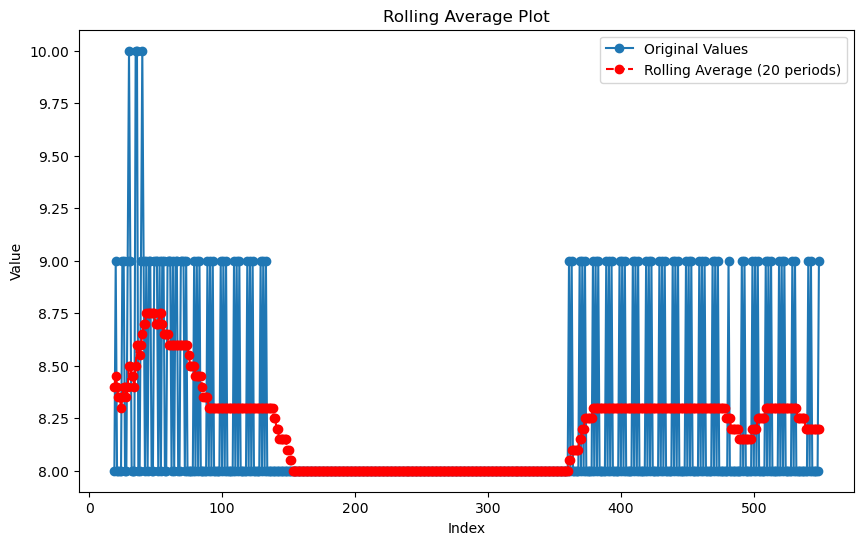

8.26
0.4386342439892262
8.25
0.4330127018922193
Gibb sampling on sample index:  0 outer it:  55
it:  0  || Likelihood:  -22931.74380468699  || n_components:  8
Gibb sampling on sample index:  1 outer it:  55
it:  0  || Likelihood:  -23204.780985237718  || n_components:  9
Gibb sampling on sample index:  2 outer it:  55
it:  0  || Likelihood:  -22704.19252118203  || n_components:  8
Gibb sampling on sample index:  3 outer it:  55
it:  0  || Likelihood:  -23052.079903039394  || n_components:  9
Gibb sampling on sample index:  4 outer it:  55
it:  0  || Likelihood:  -23798.868233982907  || n_components:  8
Gibb sampling on sample index:  5 outer it:  55
it:  0  || Likelihood:  -22618.04754184272  || n_components:  8
Gibb sampling on sample index:  6 outer it:  55
it:  0  || Likelihood:  -23360.59074844758  || n_components:  8
Gibb sampling on sample index:  7 outer it:  55
it:  0  || Likelihood:  -22688.036336871777  || n_components:  8
Gibb sampling on sample index:  8 outer it:  55
it: 

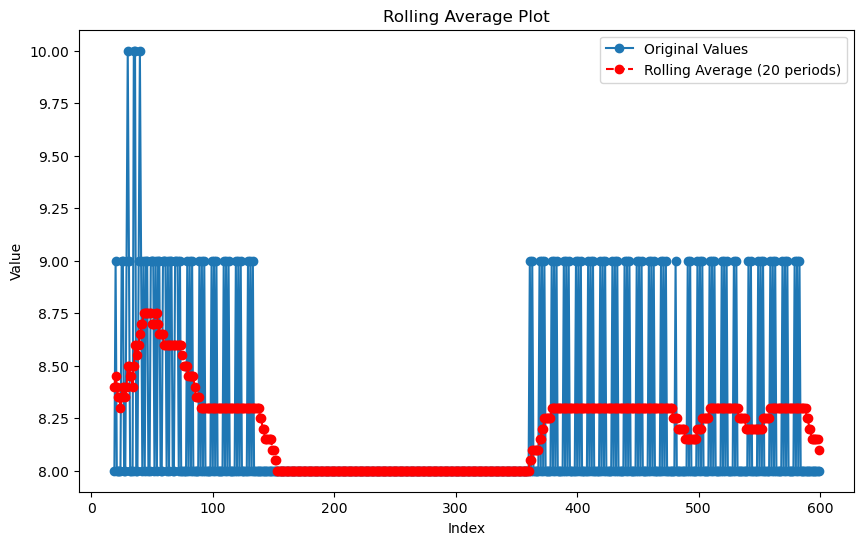

8.22
0.41424630354415964
8.24
0.4270831300812525
Gibb sampling on sample index:  0 outer it:  60
it:  0  || Likelihood:  -22998.018587625098  || n_components:  8
Gibb sampling on sample index:  1 outer it:  60
it:  0  || Likelihood:  -23255.867617425833  || n_components:  8
Gibb sampling on sample index:  2 outer it:  60
it:  0  || Likelihood:  -22703.044470866986  || n_components:  8
Gibb sampling on sample index:  3 outer it:  60
it:  0  || Likelihood:  -23118.27007321263  || n_components:  8
Gibb sampling on sample index:  4 outer it:  60
it:  0  || Likelihood:  -23846.786493901873  || n_components:  8
Gibb sampling on sample index:  5 outer it:  60
it:  0  || Likelihood:  -22608.135784278646  || n_components:  8
Gibb sampling on sample index:  6 outer it:  60
it:  0  || Likelihood:  -23299.65144596111  || n_components:  8
Gibb sampling on sample index:  7 outer it:  60
it:  0  || Likelihood:  -22702.892353623247  || n_components:  8
Gibb sampling on sample index:  8 outer it:  60
i

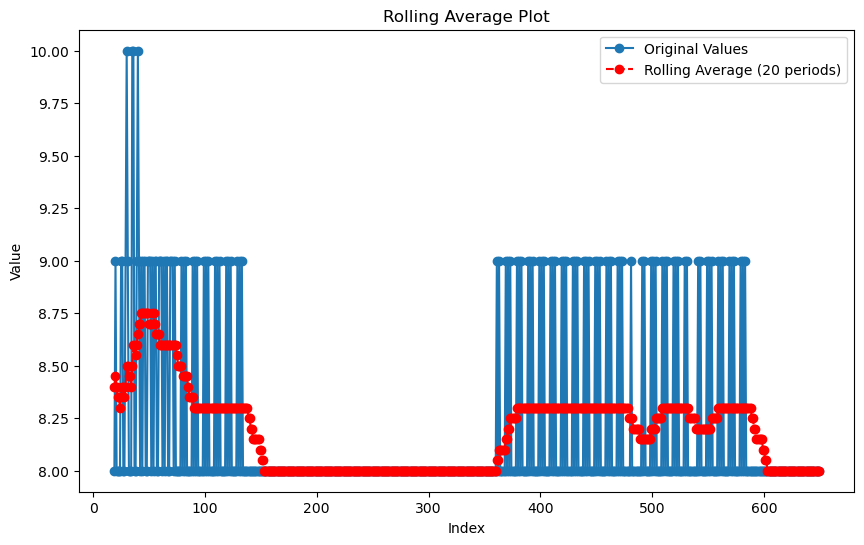

8.0
0.0
8.11
0.3128897569432403
Gibb sampling on sample index:  0 outer it:  65
it:  0  || Likelihood:  -22964.22281590644  || n_components:  8
Gibb sampling on sample index:  1 outer it:  65
it:  0  || Likelihood:  -23261.276695350538  || n_components:  8
Gibb sampling on sample index:  2 outer it:  65
it:  0  || Likelihood:  -22678.813166312877  || n_components:  8
Gibb sampling on sample index:  3 outer it:  65
it:  0  || Likelihood:  -23074.750204640786  || n_components:  8
Gibb sampling on sample index:  4 outer it:  65
it:  0  || Likelihood:  -23890.07866418408  || n_components:  8
Gibb sampling on sample index:  5 outer it:  65
it:  0  || Likelihood:  -22659.960820886132  || n_components:  8
Gibb sampling on sample index:  6 outer it:  65
it:  0  || Likelihood:  -23338.974366059003  || n_components:  8
Gibb sampling on sample index:  7 outer it:  65
it:  0  || Likelihood:  -22638.491244087196  || n_components:  8
Gibb sampling on sample index:  8 outer it:  65
it:  0  || Likelih

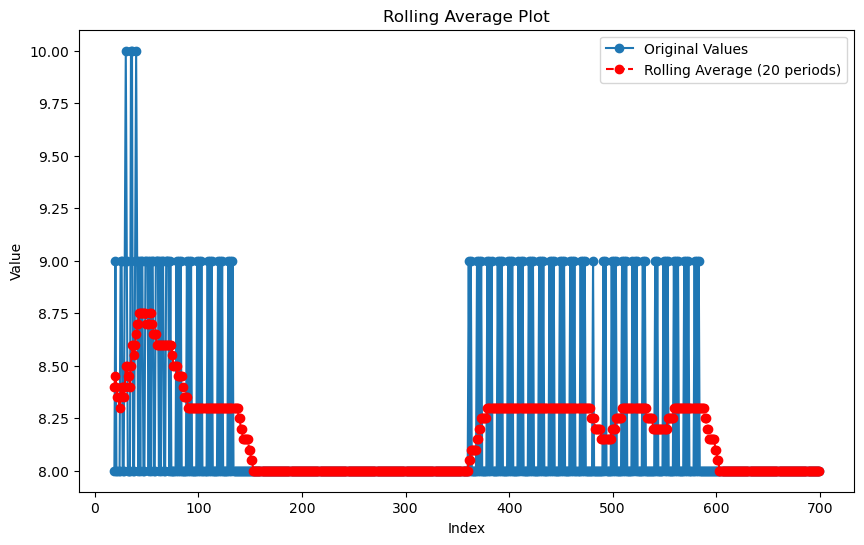

8.0
0.0
8.0
0.0
Gibb sampling on sample index:  0 outer it:  70
it:  0  || Likelihood:  -22977.48886071043  || n_components:  8
Gibb sampling on sample index:  1 outer it:  70
it:  0  || Likelihood:  -23285.452581988095  || n_components:  8
Gibb sampling on sample index:  2 outer it:  70
it:  0  || Likelihood:  -22689.017079227488  || n_components:  8
Gibb sampling on sample index:  3 outer it:  70
it:  0  || Likelihood:  -23084.396378062742  || n_components:  8
Gibb sampling on sample index:  4 outer it:  70
it:  0  || Likelihood:  -23867.69972208669  || n_components:  8
Gibb sampling on sample index:  5 outer it:  70
it:  0  || Likelihood:  -22677.36459718309  || n_components:  8
Gibb sampling on sample index:  6 outer it:  70
it:  0  || Likelihood:  -23349.30256267558  || n_components:  8
Gibb sampling on sample index:  7 outer it:  70
it:  0  || Likelihood:  -22651.595174542726  || n_components:  8
Gibb sampling on sample index:  8 outer it:  70
it:  0  || Likelihood:  -23866.96591

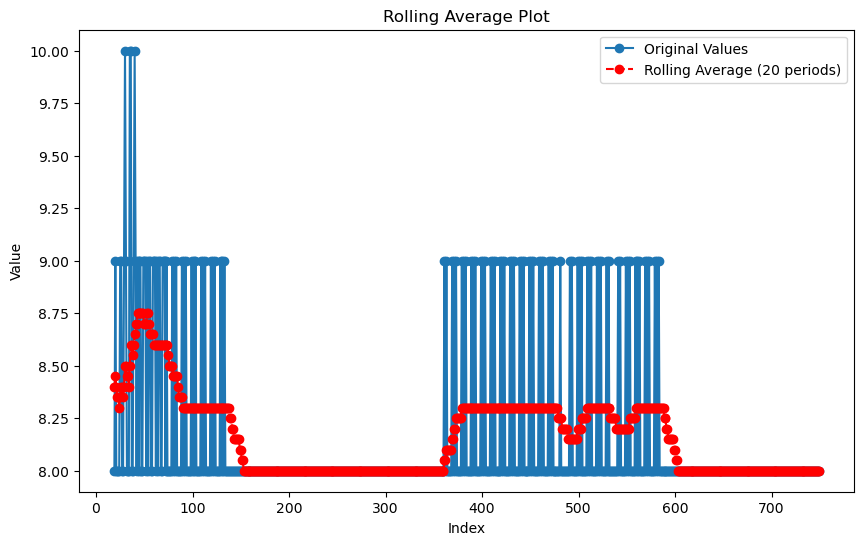

8.0
0.0
8.0
0.0
Gibb sampling on sample index:  0 outer it:  75
it:  0  || Likelihood:  -22943.440725539018  || n_components:  8
Gibb sampling on sample index:  1 outer it:  75
it:  0  || Likelihood:  -23264.406998929193  || n_components:  8
Gibb sampling on sample index:  2 outer it:  75
it:  0  || Likelihood:  -22644.644989941728  || n_components:  8
Gibb sampling on sample index:  3 outer it:  75
it:  0  || Likelihood:  -23115.475253698616  || n_components:  8
Gibb sampling on sample index:  4 outer it:  75
it:  0  || Likelihood:  -23862.917648657793  || n_components:  8
Gibb sampling on sample index:  5 outer it:  75
it:  0  || Likelihood:  -22673.82213671368  || n_components:  8
Gibb sampling on sample index:  6 outer it:  75
it:  0  || Likelihood:  -23329.611027105853  || n_components:  8
Gibb sampling on sample index:  7 outer it:  75
it:  0  || Likelihood:  -22685.12654675461  || n_components:  8
Gibb sampling on sample index:  8 outer it:  75
it:  0  || Likelihood:  -23766.414

KeyboardInterrupt: 

In [144]:
hdp_hmm.fit_multiple(verbose=True, outer_its=100, iterations=1, burn_in=1)

# plt.plot(range(0,len(hdp_hmm.trace[const.TIME])), hdp_hmm.trace[const.TIME], marker="None")
# plt.xlabel('iteration')
# plt.ylabel('ARI')
# plt.xlim(0,1)
# #plt.savefig("./image/ari.png")
# plt.show()
# plt.close()
print('average time for one gibbs sweep: ', np.mean(hdp_hmm.trace[const.TIME]))

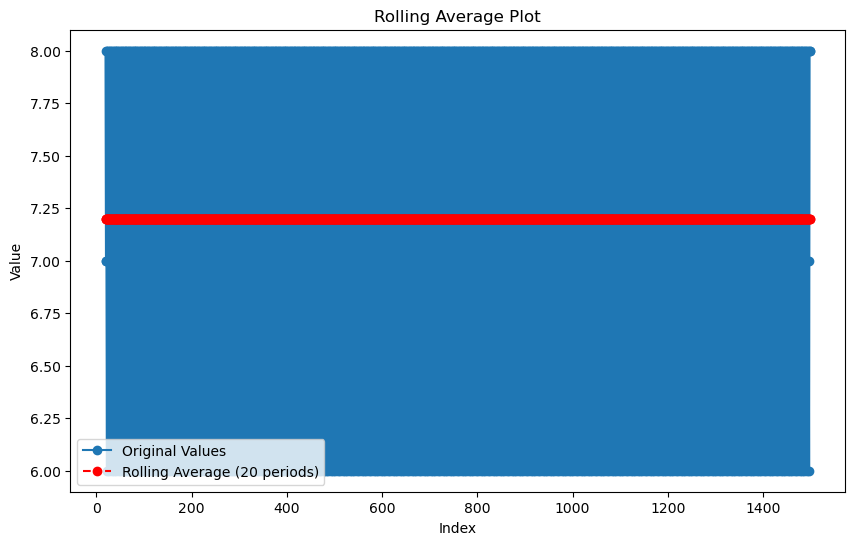

In [160]:
import matplotlib.pyplot as plt

data = hdp_hmm.trace['n_components_all']
# Define the window size for the rolling average
window_size = 20

# Create a kernel for the rolling average
kernel = np.ones(window_size) / window_size

# Use np.convolve to calculate the rolling average
rolling_avg = np.convolve(data, kernel, mode='valid')

# Create an array of indices corresponding to the original data for plotting
indices = np.arange(window_size - 1, len(data))

# Plot the data and rolling average
plt.figure(figsize=(10, 6))
plt.plot(indices, data[window_size - 1:], label='Original Values', marker='o')
plt.plot(indices, rolling_avg, label=f'Rolling Average ({window_size} periods)', color='red', linestyle='--', marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Rolling Average Plot')
plt.legend()
plt.show()

In [137]:
np.mean(hdp_hmm.trace['n_components'])

9.46

In [157]:
trace = hdp_hmm.trace

In [158]:
nk = np.copy(trace['nk'])[-100:]
nk_sum = np.sum(nk, axis=0)

In [159]:
from hmmlearn.hmm import GaussianHMM
# create am hmm from the trace
def hmm_from_trace(n_components, average_over=100):

    # from the last 'average_over' its, get the sum
    nk = np.copy(trace['nk'])[-average_over:]
    nk_sum = np.sum(nk, axis=0)

    largest_indices = np.argpartition(nk_sum, -n_components)[-n_components:]
    # nk_sum_norm = (nk_sum / np.sum(nk_sum)) * 100

    mu_matrix = np.mean(np.array(trace['mu'][-average_over:]), axis=0)[largest_indices]
    sigma_matrix = np.mean(np.array(trace['covar'][-average_over:]), axis=0)[largest_indices]
    A = np.mean(np.array(trace['A'][-average_over:]), axis=0)[largest_indices][:, largest_indices]
    pi = np.mean(np.array(trace['pie'][-average_over:]), axis=0)[largest_indices]

    hmm_trace = GaussianHMM(len(largest_indices), covariance_type='diag')
    hmm_trace.n_features = mu_matrix.shape[1]
    hmm_trace.transmat_, hmm_trace.startprob_, hmm_trace.means_ = hdp_hmm.normalize_matrix(A), hdp_hmm.normalize_matrix(pi), mu_matrix
    hmm_trace.covars_ = np.array([np.diag(i) for i in sigma_matrix])

    return hmm_trace

new_hmm_trace = hmm_from_trace(8, average_over=10)
# rem_ind = zero_indices.astype(int)
# A = A[rem_ind][:, rem_ind]
# pi = pi[rem_ind]
# means = means[rem_ind]
# covar = covar[rem_ind]
# n_components = len(rem_ind)

In [163]:
# save humpback whale pickle

# print("Writing to pickle file: " + BASENAME + ".pkl")
output = open('BowheadWhaleHMM' + ".pkl", "wb")
pickle.dump(new_hmm_trace, output)

In [165]:
# hmm check
with open('/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing/BowheadWhaleHMM.pkl', 'rb') as file:
    hmm_check = pickle.load(file)

In [115]:
mu_smaller = trace['mu'][-300:]
# index 2 is largest

In [116]:
feature_index_a = 14
feature_index_b = 15
mu_feature_index_a = []
mu_feature_index_b = []
for i in range(len(mu_smaller)):
    curr_mu = mu_smaller[i]
    mu_feature_index_a.append(curr_mu[14][14])
    mu_feature_index_b.append(curr_mu[14][15])

In [ ]:
import matplotlib.pyplot as plt

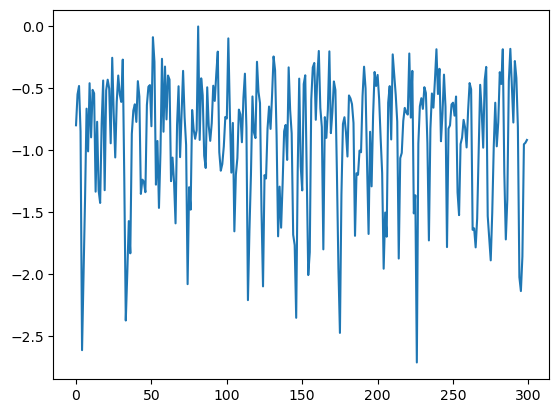

In [117]:
# plt.scatter(mu_feature_index_a, mu_feature_index_b)
plt.plot(mu_feature_index_a)
plt.show()

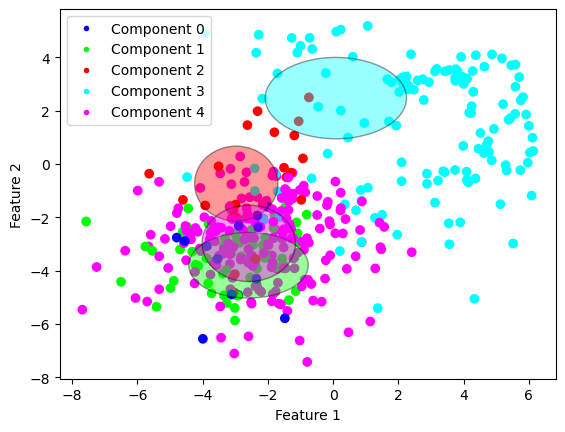

In [119]:
plot_hmm.plot_hmm_learn(concatenated_list[0], hdp_hmm.hmm, 5, 14, 16)

In [153]:
from hmmlearn.hmm import GaussianHMM
hdp_hmm.create_hmm()
hmm_hdp_diag = hdp_hmm.hmm
hdp_hmm.create_hmm('full')
hmm_hdp_full = hdp_hmm.hmm
hdp_hmm.create_hmm()

In [154]:
hmm_hdp_diag.fit(np.concatenate(train_filtered_features))
hmm_hdp_full.fit(np.concatenate(train_filtered_features))

GaussianHMM(covariance_type='full', init_params='', n_components=8)

In [155]:
hmm_em_diag = GaussianHMM(8, covariance_type='diag')
hmm_em_diag.fit(np.concatenate(train_filtered_features))
hmm_em_full = GaussianHMM(8, covariance_type='full')
hmm_em_full.fit(np.concatenate(train_filtered_features))

GaussianHMM(covariance_type='full', n_components=8)

In [160]:
print('hdp_hmm          ', hdp_hmm.hmm.score(test_filtered_features[0]))
print('hdp_hmm trace:   ', new_hmm_trace.score(test_filtered_features[0]))
print('hdp_hmm diag:    ', hmm_hdp_diag.score(test_filtered_features[0]))
print('hdp_hmm full:    ', hmm_hdp_full.score(test_filtered_features[0]))
print('hmm_em diag:     ', hmm_em_diag.score(test_filtered_features[0]))
print('hmm_em full:     ', hmm_em_full.score(test_filtered_features[0]))


hdp_hmm           -49270.06403087802
hdp_hmm trace:    -48747.94508424771
hdp_hmm diag:     -48693.111382323
hdp_hmm full:     -46193.8485810986
hmm_em diag:      -48813.365784674024
hmm_em full:      -46185.269318167055


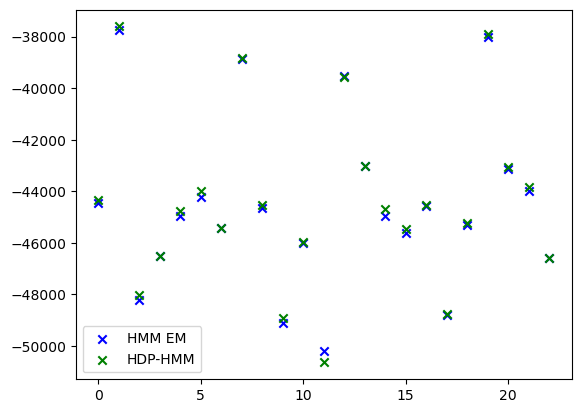

In [162]:
hmm_em_diag_lik = []
hmm_em_full_lik = []
hdp_hmm_lik = []
hdp_hmm_trace_lik = []
hmm_hdp_diag_lik = []
hmm_hdp_covar_lik = []

val_test_concat = val_filtered_features + test_filtered_features

for i in range(len(val_test_concat)):
    hmm_em_diag_lik.append(hmm_em_diag.score(val_test_concat[i]))
    hmm_em_full_lik.append(hmm_em_full.score(val_test_concat[i]))
    hdp_hmm_lik.append(hdp_hmm.hmm.score(val_test_concat[i]))
    hdp_hmm_trace_lik.append(new_hmm_trace.score(val_test_concat[i]))
    hmm_hdp_diag_lik.append(hmm_hdp_diag.score(val_test_concat[i]))
    hmm_hdp_covar_lik.append(hmm_hdp_full.score(val_test_concat[i]))

import matplotlib.pyplot as plt
x_axis = np.arange(len(hdp_hmm_lik))
plt.xlim()

# plt.scatter(x_axis, hmm_hdp_covar_lik, label='HDP-HMM EM full', c='r', marker='o')
# plt.scatter(x_axis, hmm_hdp_diag_lik, label='HDP-HMM Em diag', c='r', marker='o')
#
# plt.scatter(x_axis, hmm_em_full_lik, label='HMM full', c='blue', marker='x')
plt.scatter(x_axis, hmm_em_diag_lik, label='HMM EM', c='blue', marker='x')

# plt.scatter(x_axis, hdp_hmm_lik, label='HDP-HMM', c='grey')
plt.scatter(x_axis, hdp_hmm_trace_lik, label='HDP-HMM', c='g', marker='x')

plt.legend(loc='lower left')

In [126]:
np.exp(hdp_hmm_lik[1])

0.0

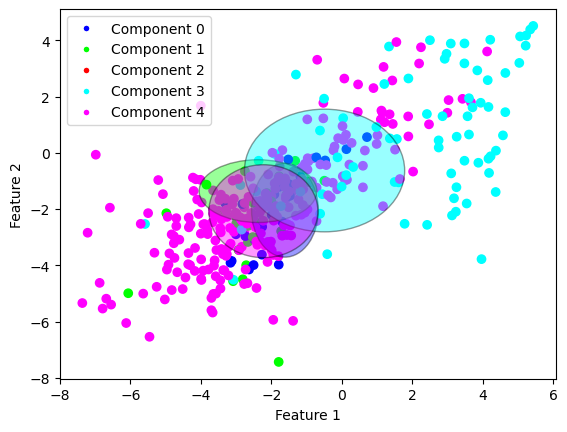

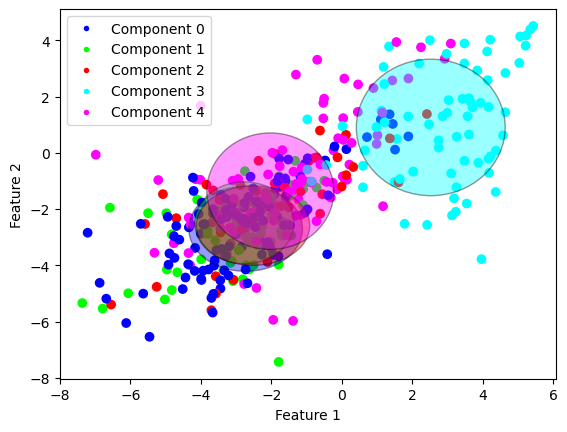

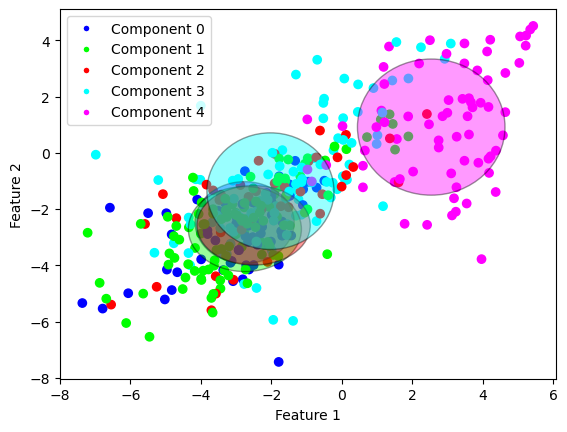

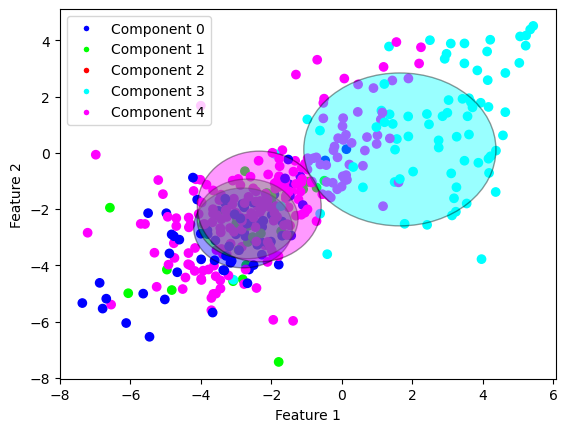

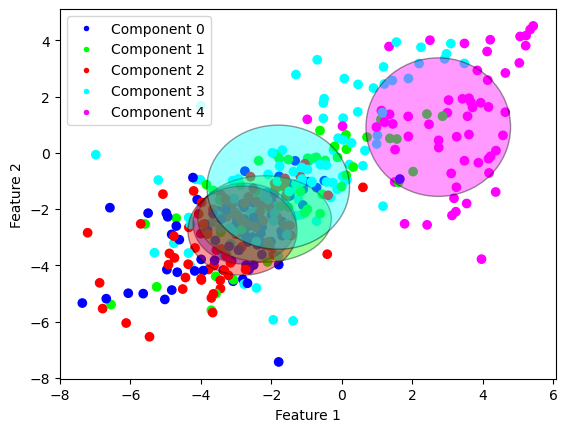

In [127]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hdp_hmm.hmm, 0.1, 14, 13)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hmm_hdp_diag, 0.1, 14, 13)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hmm_em_diag, 0.1, 14, 13)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hmm_hdp_full, 0.1, 14, 13)
plot_hmm.plot_hmm_learn(test_filtered_features[-1], hmm_em_full, 0.1, 14, 13)

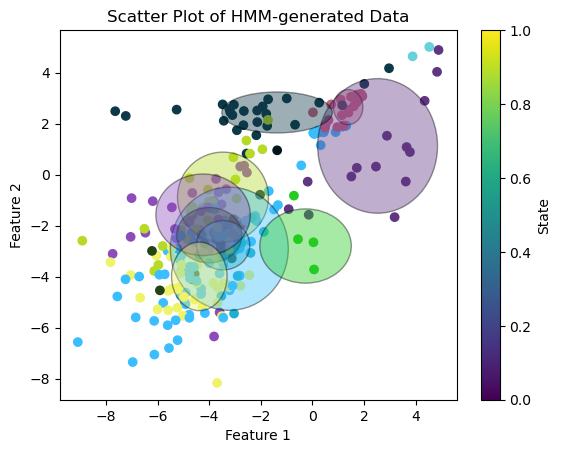

In [105]:
plot_hmm.plot_hmm_data(aic_states_humpback[3], hdp_hmm.Z, hdp_hmm.K, hdp_hmm.mu, hdp_hmm.sigma, counts=hdp_hmm.nk, percent=1,feature_a=11, feature_b=12)

In [46]:
gibbs_hmm = hdp_hmm.hmm
em_hmm = GaussianHMM(10, covariance_type='diag')
em_hmm.fit(smaller_features)
ll_gibbs, _ = gibbs_hmm.decode(smaller_features)
ll_em, ss_em = em_hmm.decode(smaller_features)
print('gibbs: ', ll_gibbs, 'em: ', ll_em)

gibbs:  -26370.479803144364 em:  -26718.644665980133


In [47]:
gibbs_hmm.fit(smaller_features)

GaussianHMM(init_params='', n_components=18)

In [48]:
ll_gibbs, _ = gibbs_hmm.decode(smaller_features)
ll_em, ss_em = em_hmm.decode(smaller_features)
print('gibbs: ', ll_gibbs, 'em: ', ll_em)

gibbs:  -24635.587943985214 em:  -26718.644665980133


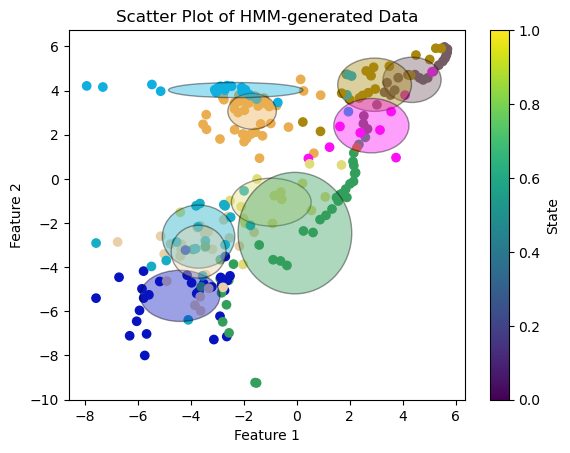

In [49]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_data(smaller_features, ss_em, em_hmm.n_components, em_hmm.means_, em_hmm.covars_, feature_a=11, feature_b=12)